In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
def read_implant_positions(file):
    with open(file, 'r') as f:
        subnetworks = []
        disease_genes = []
        for subnet in f.readlines():
            if subnet.startswith('#'):
                continue
            vals = [int(i.strip()) for i in subnet.strip().split(':')[1].strip().split('\t')]
            subnetworks.append(vals)
            disease_genes.append(vals[0])
    return pd.DataFrame(subnetworks), disease_genes

def get_top_n_both(scores, disease_genes, n):
    return scores.head(n)[scores.head(n).index.isin(disease_genes)]

def get_recovered_nodes(scores, subnets):
    idx = []
    for score in scores.index:
        if subnets[subnets.isin([int(score)]).any(axis=1)].shape[0] > 0:
            idx.append(score)
    return scores.loc[idx]

In [15]:
model_dir = '../data/GCN/training/2018_01_30_16_54_25/'

predictions = []
for file in os.listdir(model_dir):
    if file.startswith('predictions_'):
        df = pd.read_csv(os.path.join(model_dir, file), sep='\t')
        predictions.append(df)

In [18]:
subnets, disease_genes = read_implant_positions('../data/simulation/implant_positions.txt')
p = predictions[0]

recovered_diseasegenes = p[p.index.isin(disease_genes)]
recovered_diseasegenes[recovered_diseasegenes.Prob_pos > 0.5].shape

(21, 3)

In [22]:
gcn_idx = []
for score in p.index:
    if subnets[subnets.isin([int(score)]).any(axis=1)].shape[0] > 0:
        gcn_idx.append(score)
pred_for_subnets = p.loc[gcn_idx]
pred_for_subnets.shape

(190, 3)

In [23]:
recovered = pred_for_subnets[pred_for_subnets.Prob_pos > .5]

In [25]:
recovered.shape, p[p.Prob_pos > 0.5].shape

((103, 3), (548, 3))

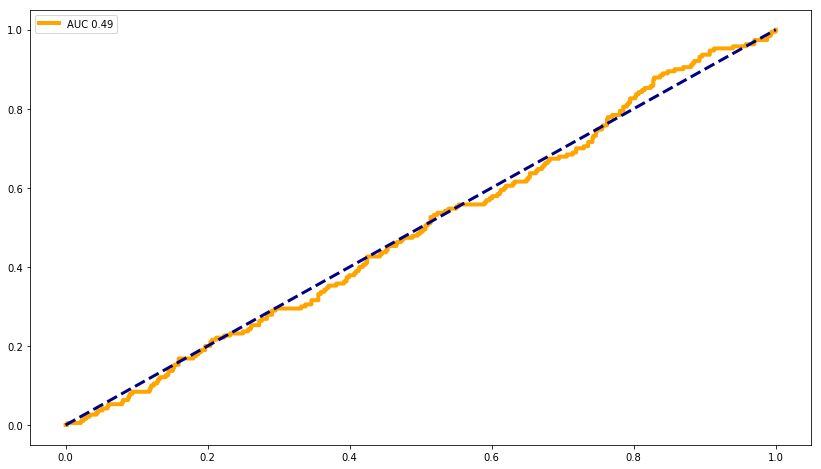

In [27]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
%matplotlib inline
subnet_entries = subnets.values.flatten()
y_true = p.index.isin(subnet_entries)
y_score = p.Prob_pos
tpr, fpr, _ = roc_curve(y_score=y_score, y_true=y_true)
auc = roc_auc_score(y_score=y_score, y_true=y_true)
fig = plt.figure(figsize=(14, 8))
plt.plot(tpr, fpr, lw=4, color='orange', label='AUC {0:.2f}'.format(auc))
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.legend()
fig.savefig(model_dir + 'roc_curve.png', dpi=300)

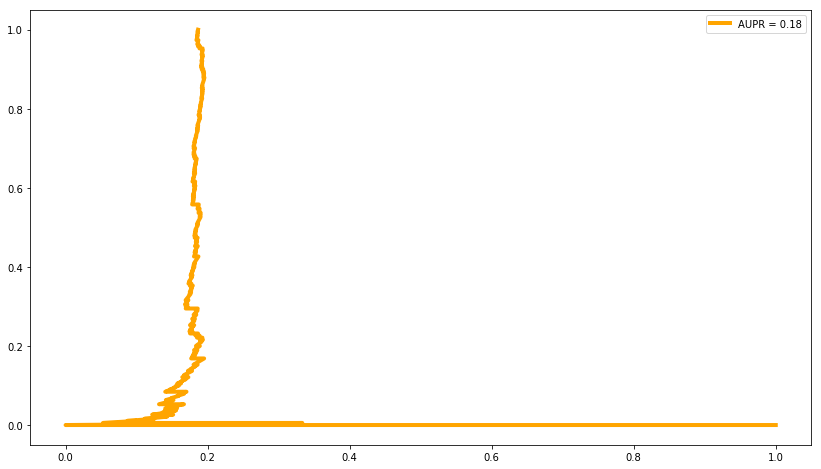

In [28]:
from sklearn.metrics import precision_recall_curve, average_precision_score
avg_prec = average_precision_score(y_true, y_score)
pr, rc, _ = precision_recall_curve(y_true, y_score)
fig = plt.figure(figsize=(14, 8))
plt.plot(pr, rc, lw=4, color='orange', label='AUPR = {0:.2f}'.format(avg_prec))
plt.legend()
fig.savefig(model_dir + 'prec_recall_curve.png', dpi=300)